In [3]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pickle
import sys
from sys import exc_info
import ast
from sklearn import metrics

In [5]:
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict


In [6]:
! git clone https://github.com/divensambhwani/MovieLens-100K_Recommender-System.git  > /dev/null 2>&1


In [ ]:
ratings = pd.read_csv('/content/MovieLens-100K_Recommender-System/data/ratings.csv', usecols = ['userId', 'movieId','rating'])

In [ ]:
ratings = ratings[ratings['rating'] >= 4.0]
movies_list = np.unique(ratings['movieId'])[:200]
ratings = ratings.loc[ratings['movieId'].isin(movies_list)]

In [ ]:
ratings.head(4)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0


In [ ]:
print('Shape of ratings dataset is: ',ratings.shape, '\n')

Shape of ratings dataset is:  (3504, 3) 



In [ ]:
users_list = np.unique(ratings['userId'])[:100]
ratings = ratings.loc[ratings['userId'].isin(users_list)]

users_fav_movies = ratings.loc[:, ['userId', 'movieId']]
users_fav_movies = ratings.reset_index(drop = True)

users_fav_movies.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763
userId,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,107.0,107.0,107.0,107.0,108.0,108.0,108.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,110.0,110.0,111.0,111.0,111.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,113.0,113.0,113.0,113.0
movieId,1.0,3.0,6.0,47.0,50.0,101.0,110.0,151.0,157.0,163.0,216.0,231.0,235.0,260.0,106.0,125.0,162.0,176.0,215.0,232.0,260.0,265.0,1.0,21.0,34.0,36.0,50.0,58.0,110.0,232.0,247.0,261.0,2.0,3.0,5.0,6.0,7.0,11.0,15.0,16.0,...,161.0,185.0,253.0,266.0,25.0,82.0,156.0,11.0,14.0,16.0,25.0,32.0,36.0,50.0,62.0,110.0,151.0,175.0,249.0,47.0,111.0,16.0,39.0,145.0,6.0,16.0,19.0,32.0,47.0,50.0,62.0,104.0,141.0,150.0,253.0,260.0,111.0,222.0,260.0,265.0
rating,4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0,5.0,4.0,4.5,4.0,4.5,4.0,4.0,4.5,4.5,4.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.5,5.0,4.0,4.0,4.0,5.0


In [ ]:
users_fav_movies.to_csv('/content/MovieLens-100K_Recommender-System/data/filtered_ratings.csv')

In [ ]:
def moviesListForUsers(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return users_movies_list

In [ ]:
users = np.unique(users_fav_movies['userId'])
print(users.shape)

(100,)


In [ ]:
users_movies_list = moviesListForUsers(users, users_fav_movies)
print('Movies list for', len(users_movies_list), ' users')
print('A list of first 10 users favourite movies: \n', users_movies_list[:10])

Movies list for 100  users
A list of first 10 users favourite movies: 
 ['1, 3, 6, 47, 50, 101, 110, 151, 157, 163, 216, 231, 235, 260', '106, 125, 162, 176, 215, 232, 260, 265', '1, 21, 34, 36, 50, 58, 110, 232, 247, 261', '2, 3, 5, 6, 7, 11, 15, 16, 17, 22, 24, 26, 32, 34, 36, 41, 43, 46, 47, 54, 60, 61, 62, 76, 86, 89, 92, 93, 95, 104, 110, 112, 141, 145, 146, 150, 151, 158, 160, 168, 195, 207, 210, 212, 216, 222, 225, 230, 236, 237, 248, 250, 252, 257, 261, 262', '1, 50, 150, 165, 260', '2, 11, 21, 34, 47, 50, 150, 185, 186, 231, 253', '223', '6, 36, 110, 150, 170', '39, 168, 222, 256, 261', '47']


In [ ]:
def prepSparseMatrix(list_of_str):
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names()

In [ ]:
sparseMatrix, feature_names = prepSparseMatrix(users_movies_list)

In [ ]:
feature_names[2]

'100'

In [ ]:
kmeans = KMeans(n_clusters=15, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans = kmeans.fit(sparseMatrix)
clusters = kmeans.fit_predict(sparseMatrix)

In [ ]:
from sklearn.metrics import silhouette_score

print(silhouette_score(sparseMatrix, kmeans.labels_))

0.04553817190126924


In [ ]:
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
userId,1,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,42,43,44,45,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113
Cluster,0,1,0,4,0,0,3,3,3,3,0,1,3,0,7,1,3,1,3,3,3,1,3,1,1,3,1,3,13,0,3,0,3,0,1,12,8,6,1,9,...,0,3,3,1,1,1,3,1,0,3,3,3,2,3,1,3,3,3,1,7,3,1,11,1,0,3,10,14,3,3,0,3,0,5,3,0,3,3,0,1


In [ ]:
def clustersMovies(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_movies = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['userId'])
        users_movies_list = list()
        for user in users_list:    
            users_movies_list.extend(list(users_data[users_data['userId'] == user]['movieId']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['movieId', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies

In [ ]:
cluster_movies = clustersMovies(users_cluster, users_fav_movies)

In [ ]:
cluster_movies[1].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
movieId,260,10,110,2,34,47,6,39,111,32,70,50,208,1,176,168,48,162,150,104,231,153,265,7,36,11,25,246,163,164,258,165,247,232,236,161,173,177,207,235,215,222,225,170,105,158,60,3,14,15,17,18,19,29,41,52,58,62,125,69,76,82,85,86,94,95,106,112,116,266
Count,25,4,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
def getMoviesOfUser(user_id, users_data):
    return list(users_data[users_data['userId'] == user_id]['movieId'])

In [ ]:
def fixClusters(clusters_movies_dataframes, users_cluster_dataframe, users_data, smallest_cluster_size = 11):
    each_cluster_movies = clusters_movies_dataframes.copy()
    users_cluster = users_cluster_dataframe.copy()
    each_cluster_movies_list = [list(df['movieId']) for df in each_cluster_movies]
    usersInClusters = list()
    total_clusters = len(each_cluster_movies)
    for i in range(total_clusters):
        usersInClusters.append(list(users_cluster[users_cluster['Cluster'] == i]['userId']))
    uncategorizedUsers = list()
    i = 0
    for j in range(total_clusters):
        if len(usersInClusters[i]) < smallest_cluster_size:
            uncategorizedUsers.extend(usersInClusters[i])
            usersInClusters.pop(i)
            each_cluster_movies.pop(i)
            each_cluster_movies_list.pop(i)
            users_cluster.loc[users_cluster['Cluster'] > i, 'Cluster'] -= 1
            i -= 1
        i += 1
    for user in uncategorizedUsers:
        elemProbability = list()
        user_movies = getMoviesOfUser(user, users_data)
        if len(user_movies) == 0:
            print(user)
        user_missed_movies = list()
        for movies_list in each_cluster_movies_list:
            count = 0
            missed_movies = list()
            for movie in user_movies:
                if movie in movies_list:
                    count += 1
                else:
                    missed_movies.append(movie)
            elemProbability.append(count / len(user_movies))
            user_missed_movies.append(missed_movies)
        user_new_cluster = np.array(elemProbability).argmax()
        users_cluster.loc[users_cluster['userId'] == user, 'Cluster'] = user_new_cluster
        if len(user_missed_movies[user_new_cluster]) > 0:
            each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'movieId': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]], ignore_index = True)
    return each_cluster_movies, users_cluster

In [ ]:
movies_df_fixed, clusters_fixed = fixClusters(cluster_movies, users_cluster, users_fav_movies, smallest_cluster_size = 6)

In [ ]:
global file

class saveLoadFiles:
    def save(self, filename, data):
        try:
            file = open('/content/MovieLens-100K_Recommender-System/data/' + filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            # file.close()
            return [False, err]
        else:
            file.close()
            return [True]
    def load(self, filename):
        try:
            file = open('/content/MovieLens-100K_Recommender-System/data/' + filename + '.pkl', 'rb')
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            data = pickle.load(file)
            file.close()
            return data
    def loadClusterMoviesDataset(self):
        return self.load('clusters_movies_dataset')
    def saveClusterMoviesDataset(self, data):
        return self.save('clusters_movies_dataset', data)
    def loadUsersClusters(self):
        return self.load('users_clusters')
    def saveUsersClusters(self, data):
        return self.save('users_clusters', data)

In [ ]:
saveLoadFile = saveLoadFiles()
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed))
print(saveLoadFile.saveUsersClusters(clusters_fixed))

[True]
[True]


In [ ]:
load_movies_list, load_users_clusters = saveLoadFile.loadClusterMoviesDataset(), saveLoadFile.loadUsersClusters()

In [ ]:
class userRequestedFor:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        users_cluster = saveLoadFiles().loadUsersClusters()
        print(users_cluster.shape)
        self.user_cluster = int(users_cluster[users_cluster['userId'] == self.user_id]['Cluster'])
        self.movies_list = saveLoadFiles().loadClusterMoviesDataset()
        print(movies_list.shape)
        self.cluster_movies = self.movies_list[self.user_cluster] # dataframe
        self.cluster_movies_list = list(self.cluster_movies['movieId']) # list
    def updatedFavouriteMoviesList(self, new_movie_Id):
        if new_movie_Id in self.cluster_movies_list:
            self.cluster_movies.loc[self.cluster_movies['movieId'] == new_movie_Id, 'Count'] += 1
        else:
            self.cluster_movies = self.cluster_movies.append([{'movieId':new_movie_Id, 'Count': 1}], ignore_index=True)
        self.cluster_movies.sort_values(by = ['Count'], ascending = False, inplace= True)
        self.movies_list[self.user_cluster] = self.cluster_movies
        saveLoadFiles().saveClusterMoviesDataset(self.movies_list)

    def recommendMostFavouriteMovies(self):
        try:
            user_movies = getMoviesOfUser(self.user_id, self.users_data)
            cluster_movies_list = self.cluster_movies_list.copy()
            print(self.user_id)
            for user_movie in user_movies:
                if user_movie in cluster_movies_list:
                    cluster_movies_list.remove(user_movie)
            return [True, cluster_movies_list]
        except KeyError:
            err = "User history does not exist"
            print(err)
            return [False, err]
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            return [False, err]

In [ ]:
movies_metadata = pd.read_csv(
    'MovieLens-100K_Recommender-System/data/movies_metadata.csv', 
    usecols = ['id', 'genres', 'original_title'])

movies_metadata = movies_metadata.loc[
    movies_metadata['id'].isin(list(map(str, np.unique(users_fav_movies['movieId']))))].reset_index(drop=True)
print('Let take a look at movie metadata for all those movies which we were had in our dataset')
movies_metadata.head(5)

Let take a look at movie metadata for all those movies which we were had in our dataset


,genres,id,original_title
0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,Four Rooms
1,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",76,Before Sunrise
2,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",11,Star Wars
3,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",101,Léon
4,"[{'id': 18, 'name': 'Drama'}, {'id': 9648, 'na...",110,Trois couleurs : Rouge


In [ ]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:15]:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre['name'], ', ', end = '')
        print(']', end = '')
        print()

(100, 2)
(200,)
12
Movie title:  ['Back to the Future Part II'] , Genres: [Adventure , Comedy , Family , Science Fiction , ]
Movie title:  ['48 Hrs.'] , Genres: [Thriller , Action , Comedy , Crime , Drama , ]
Movie title:  ['Rebecca'] , Genres: [Drama , Mystery , ]
Movie title:  ['Scarface'] , Genres: [Action , Crime , Drama , Thriller , ]
Movie title:  ['Trois couleurs : Rouge'] , Genres: [Drama , Mystery , Romance , ]
Movie title:  ['Judgment Night'] , Genres: [Action , Thriller , Crime , ]
Movie title:  ['Syriana'] , Genres: [Drama , Thriller , ]
Movie title:  ['Breaking the Waves'] , Genres: [Drama , Romance , ]
Movie title:  ['2001: A Space Odyssey'] , Genres: [Science Fiction , Mystery , Adventure , ]
Movie title:  ['Snatch'] , Genres: [Thriller , Crime , ]


**Agglo**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
hc = hc.fit(sparseMatrix)
y_hc = hc.fit_predict(sparseMatrix)

In [ ]:
print(silhouette_score(sparseMatrix, kmeans.labels_))

0.04553817190126924


In [ ]:
users_cluster_agglo = pd.DataFrame(np.concatenate((users.reshape(-1,1), y_hc.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster_agglo.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
userId,1,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,42,43,44,45,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113
Cluster,0,4,1,2,4,1,4,4,4,4,4,4,4,4,0,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,4,1,4,1,4,0,0,3,4,0,...,4,4,4,4,4,4,4,4,4,4,4,4,1,4,4,4,4,4,1,0,4,0,4,4,4,4,0,1,4,4,0,4,4,0,4,1,4,4,4,4


In [ ]:
clutster_movies_aglo = clustersMovies(users_cluster_agglo, users_fav_movies)

In [ ]:
movies_df_fixed_aglo, clusters_fixed_aglo = fixClusters(clutster_movies_aglo, users_cluster_agglo, users_fav_movies,smallest_cluster_size = 6)

In [ ]:
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed_aglo))
print(saveLoadFile.saveUsersClusters(clusters_fixed_aglo))

[True]
[True]


In [ ]:
load_movies_list, load_users_clusters = saveLoadFile.loadClusterMoviesDataset(), saveLoadFile.loadUsersClusters()

In [ ]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:15]:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre['name'], ', ', end = '')
        print(']', end = '')
        print()

(100, 2)
(200,)
12
Movie title:  ['The 39 Steps'] , Genres: [Action , Thriller , Mystery , ]
Movie title:  ['48 Hrs.'] , Genres: [Thriller , Action , Comedy , Crime , Drama , ]
Movie title:  ['Trois couleurs : Rouge'] , Genres: [Drama , Mystery , Romance , ]
Movie title:  ['Back to the Future Part II'] , Genres: [Adventure , Comedy , Family , Science Fiction , ]
Movie title:  ['Scarface'] , Genres: [Action , Crime , Drama , Thriller , ]
Movie title:  ['Judgment Night'] , Genres: [Action , Thriller , Crime , ]
Movie title:  ['Dancer in the Dark'] , Genres: [Drama , Crime , Music , ]
Movie title:  ['Rebecca'] , Genres: [Drama , Mystery , ]
Movie title:  ['Ariel'] , Genres: [Drama , Crime , ]
Movie title:  ['2001: A Space Odyssey'] , Genres: [Science Fiction , Mystery , Adventure , ]


**DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(sparseMatrix)
dbscan = DBSCAN(eps=15, min_samples=10)
model = dbscan.fit(X_std)
y_dbscan = model.fit_predict(X_std)

In [ ]:
labels = model.labels_

core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
print(core_samples)


[False False  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False False  True  True  True  True  True False
 False False  True False  True  True  True  True False  True  True  True
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True False  True  True False  True  True
  True  True False False  True  True  True  True  True False  True False
  True  True  True  True]


In [ ]:
users_cluster_dbscan = pd.DataFrame(np.concatenate((users.reshape(-1,1), y_dbscan.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster_dbscan.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
userId,1,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,42,43,44,45,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113
Cluster,-1,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,-1,-1,-1,0,-1,...,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,-1,0,0,0,0,-1,-1,0,0,0,0,0,-1,0,-1,0,0,0,0


In [ ]:
clutster_movies_dbscan = clustersMovies(users_cluster_dbscan, users_fav_movies)

In [ ]:
movies_df_fixed_dbscan, clusters_fixed_dbscan = fixClusters(clutster_movies_dbscan, users_cluster_dbscan, users_fav_movies,smallest_cluster_size = 1)

In [ ]:
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed_dbscan))
print(saveLoadFile.saveUsersClusters(clusters_fixed_dbscan))

[True]
[True]


In [ ]:
load_movies_list, load_users_clusters = saveLoadFile.loadClusterMoviesDataset(), saveLoadFile.loadUsersClusters()

In [ ]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:15]:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre['name'], ', ', end = '')
        print(']', end = '')
        print()

(100, 2)
(200,)
12
Movie title:  ['The 39 Steps'] , Genres: [Action , Thriller , Mystery , ]
Movie title:  ['Trois couleurs : Rouge'] , Genres: [Drama , Mystery , Romance , ]
Movie title:  ['48 Hrs.'] , Genres: [Thriller , Action , Comedy , Crime , Drama , ]
Movie title:  ['Scarface'] , Genres: [Action , Crime , Drama , Thriller , ]
Movie title:  ['Back to the Future Part II'] , Genres: [Adventure , Comedy , Family , Science Fiction , ]
Movie title:  ['Judgment Night'] , Genres: [Action , Thriller , Crime , ]
Movie title:  ['Dancer in the Dark'] , Genres: [Drama , Crime , Music , ]
Movie title:  ['Rebecca'] , Genres: [Drama , Mystery , ]
Movie title:  ['Live and Let Die'] , Genres: [Adventure , Action , Thriller , ]


**MeanShift**

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(sparseMatrix, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
y_ms = ms.fit_predict(sparseMatrix)

In [ ]:
users_cluster_ms = pd.DataFrame(np.concatenate((users.reshape(-1,1), y_ms.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster_ms.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
userId,1,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,42,43,44,45,...,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,107,108,109,110,111,112,113
Cluster,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
clutster_movies_ms = clustersMovies(users_cluster_ms, users_fav_movies)

In [ ]:
movies_df_fixed_ms, clusters_fixed_ms= fixClusters(clutster_movies_ms, users_cluster_ms, users_fav_movies,smallest_cluster_size = 2)

In [ ]:
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed_ms))
print(saveLoadFile.saveUsersClusters(clusters_fixed_ms))

[True]
[True]


In [ ]:
load_movies_list, load_users_clusters = saveLoadFile.loadClusterMoviesDataset(), saveLoadFile.loadUsersClusters()

In [ ]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:15]:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [', end = '')
        genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre['name'], ', ', end = '')
        print(']', end = '')
        print()

(100, 2)
(200,)
12
Movie title:  ['The 39 Steps'] , Genres: [Action , Thriller , Mystery , ]
Movie title:  ['Trois couleurs : Rouge'] , Genres: [Drama , Mystery , Romance , ]
Movie title:  ['48 Hrs.'] , Genres: [Thriller , Action , Comedy , Crime , Drama , ]
Movie title:  ['Back to the Future Part II'] , Genres: [Adventure , Comedy , Family , Science Fiction , ]
Movie title:  ['Scarface'] , Genres: [Action , Crime , Drama , Thriller , ]
Movie title:  ['Judgment Night'] , Genres: [Action , Thriller , Crime , ]
Movie title:  ['Dancer in the Dark'] , Genres: [Drama , Crime , Music , ]
Movie title:  ['Star Wars'] , Genres: [Adventure , Action , Science Fiction , ]
Movie title:  ['2001: A Space Odyssey'] , Genres: [Science Fiction , Mystery , Adventure , ]


# **Analysis**

In [4]:
pip install surprise

     |████████████████████████████████| 11.8MB 8.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618274 sha256=93a5c80c4cd606b1377cf894fc60f3e98e49c81b8d34b084be1f857bb27c4eb4
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [7]:
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import BaselineOnly

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [9]:
ratings = pd.read_csv('/content/MovieLens-100K_Recommender-System/data/ratings.csv')
ratings.head(4)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815


In [10]:
ratings_dict = {'itemID': list(ratings.movieId),'userID': list(ratings.userId),'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)

In [11]:
reader = Reader(line_format='user item rating timestamp', sep='\t')
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [12]:
df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,itemID,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
224,260,251
418,480,238
97,110,237
507,589,224
461,527,220


In [13]:
df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]


,userID,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


In [14]:
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=35, n_epochs=25, lr_all=0.008, reg_all=0.08)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8625


0.8624816216224295

In [15]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [16]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [17]:
best_predictions


,uid,iid,rui,est,details,Iu,Ui,err
652,452,110,5.0,5.000000,{'was_impossible': False},163,162,0.000000
13997,452,1200,5.0,5.000000,{'was_impossible': False},163,87,0.000000
16064,43,1073,5.0,5.000000,{'was_impossible': False},90,86,0.000000
10716,53,249,5.0,5.000000,{'was_impossible': False},13,13,0.000000
18775,53,922,5.0,5.000000,{'was_impossible': False},13,22,0.000000
453,53,1256,5.0,5.000000,{'was_impossible': False},13,20,0.000000
4382,348,318,5.0,5.000000,{'was_impossible': False},45,231,0.000000
19981,523,318,5.0,5.000000,{'was_impossible': False},57,231,0.000000
22840,43,1356,5.0,5.000000,{'was_impossible': False},90,69,0.000000
23533,57,1479,3.0,2.999998,{'was_impossible': False},354,23,0.000002


In [18]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6521,557,2700,0.5,4.017684,{'was_impossible': False},16,56,3.517684
10423,413,1246,1.0,4.558757,{'was_impossible': False},41,65,3.558757
2185,543,5481,0.5,4.065647,{'was_impossible': False},59,47,3.565647
10179,594,7982,0.5,4.115206,{'was_impossible': False},174,3,3.615206
14966,344,3949,0.5,4.139001,{'was_impossible': False},46,67,3.639001
7739,573,1127,0.5,4.215053,{'was_impossible': False},230,49,3.715053
12331,161,4002,0.5,4.271957,{'was_impossible': False},30,21,3.771957
3588,125,4973,0.5,4.370515,{'was_impossible': False},275,94,3.870515
15009,573,44199,0.5,4.430328,{'was_impossible': False},230,29,3.930328
21506,210,296,0.5,4.492991,{'was_impossible': False},103,228,3.992991


In [19]:
df.loc[df['itemID'] == 3996]['rating'].describe()


count    110.000000
mean       3.836364
std        1.031853
min        0.500000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: rating, dtype: float64

In [21]:
final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,25209,0,0,0,1.000000,1.000000,1.000000
1,0.5,25209,0,0,0,1.000000,1.000000,1.000000
2,1.0,24864,345,0,0,0.986314,1.000000,0.993110
3,1.5,24176,1016,8,9,0.959670,0.999628,0.979241
4,2.0,23650,1373,112,74,0.945130,0.996881,0.970316
5,2.5,21408,2685,657,459,0.888557,0.979009,0.931593
6,3.0,18387,2464,2279,2079,0.881828,0.898417,0.890045
7,3.5,10747,2741,7112,4609,0.796782,0.699857,0.745181
8,4.0,4024,848,12252,8085,0.825944,0.332315,0.473941
9,4.5,455,199,19618,4937,0.695719,0.084384,0.150513


In [22]:
def precision_recall_at_k(predictions, k, threshold):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precisions, recalls

In [23]:
results=[]
for i in range(2, 5):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})

results

[{'K': 2, 'Precision': 0.9417077175697866, 'Recall': 0.16376593446195684},
 {'K': 3, 'Precision': 0.9408866995073896, 'Recall': 0.23759165519770245},
 {'K': 4, 'Precision': 0.9389709906951285, 'Recall': 0.3078095523084919}]

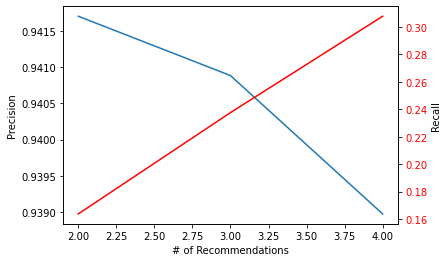

In [24]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,3):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

In [26]:
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=35, n_epochs=25, lr_all=0.008, reg_all=0.08)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [ ]:
def get_all_predictions(predictions):
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
    return top_n

In [ ]:
all_pred = get_all_predictions(predictions)

In [ ]:
n = 4
for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]

In [ ]:
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()

In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [ ]:
user_id=67
results = get_predictions(user_id)
results

0      (3451, 4.536820042694508)
1      (1217, 4.457276039174107)
2      (1104, 4.430449114779646)
3    (106642, 4.401669909194753)
Name: 67, dtype: object

In [ ]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids

[3451, 1217, 1104, 106642]

In [ ]:
movies = pd.read_csv('/content/MovieLens-100K_Recommender-System/data/movies.csv')
movies.head()
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies

,movieId,title,genres
841,1104,"Streetcar Named Desire, A (1951)",Drama
918,1217,Ran (1985),Drama|War
2582,3451,Guess Who's Coming to Dinner (1967),Drama
8301,106642,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi


In [ ]:
ratings = pd.read_csv('/content/MovieLens-100K_Recommender-System/data/ratings.csv')


ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.head()

,itemID,userID,rating
0,1,1,4.0
1,3,1,4.0
2,6,1,4.0
3,47,1,5.0
4,50,1,5.0


In [ ]:
temp = df[df['userID'] == 67].sort_values("rating", ascending = False)
history_movie_ids = temp['itemID']
user_history = movies[movies['movieId'].isin(history_movie_ids)]
user_history[:n]


,movieId,title,genres
254,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War


Now we can compare the results with the user history and see how relevant the recommendations are.
Above is the user history and below the recommended movies 


As the history of the user tells that the user mostly likes Drama movies and we are recommending all the Drama movies, which means we are recommending the right movies to the user.





In [ ]:
recommended_movies


,movieId,title,genres
841,1104,"Streetcar Named Desire, A (1951)",Drama
918,1217,Ran (1985),Drama|War
2582,3451,Guess Who's Coming to Dinner (1967),Drama
8301,106642,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
